# Tulap Mechanism

The Tulap mechanism is well-suited for privatizing estimates that follow a binomial distribution,
like a count (or boolean sum).

An example of this can be found when counting the number of married individuals in the California demographics dataset,
a microdata-level dataset with attributes for age, sex, education, race, income and marriage status.

In [1]:
![ -e data.csv ] || wget https://raw.githubusercontent.com/opendp/opendp/main/docs/source/data/PUMS_california_demographics_1000/data.csv

In [2]:
data = open("data.csv").read()

We'll use the Tulap mechanism to conduct statistical inference on the 'married' column,
where values are either 0 or 1, indicating marriage status.

The following transformation counts the number of married individuals in the dataset.

In [3]:
import opendp.prelude as dp
dp.enable_features("contrib")

t_count_married = (
    dp.t.make_split_dataframe(",", col_names=["age", "sex", "educ", "race", "income", "married"]) >>
    dp.t.make_select_column("married", str) >>
    dp.t.then_cast_default(float) >>
    dp.t.then_clamp((0., 1.)) >>
    dp.t.then_sum()
)

# what is the exact number of married individuals?
exact_estimate = t_count_married(data)
exact_estimate

549.0

The Tulap mechanism behaves similarly to the Laplace or Gaussian mechanism in that it is an additive noise mechanism.

> At this time, the implementation of the Tulap mechanism in OpenDP only supports scalar-valued float inputs with a sensitivity at most one.

In [4]:
epsilon, delta = 0.2, 1e-8
m_count_married = t_count_married >> dp.m.then_tulap(epsilon=epsilon, delta=delta)

# what is the DP estimate of the number of married individuals?
private_estimate = m_count_married(data)
private_estimate

546.2027031341229

The Tulap distribution is a combination of discrete Laplace noise and continuous uniform noise. 

## Binomial Assumption

There are utilities for conducting hypothesis tests and constructing confidence intervals 
in the setting where the input to the Tulap mechanism is binomially distributed.

To access these utilities, instantiate a `BinomialTulap` class with epsilon, delta and an estimate of the dataset size
(parameters that typically don't change across an analysis).

In [5]:
from opendp.extras.numpy.tulap import BinomialTulap
tulap_married = BinomialTulap(private_estimate, epsilon=epsilon, delta=delta, size=1_000)

Lets interpret each available API on the marriage data.

### Confidence Intervals

In [6]:
ci = tulap_married.confidence_interval(alpha=.05)
ci

(0.5123161678397707, 0.580089238428475)

With a statistical significance of .05 (with 95% confidence), the true proportion of married individuals is within the interval ``ci``.

In [7]:
lower_ci = tulap_married.confidence_interval(alpha=.05, side='lower')
lower_ci

0.517834790715473

With a statistical significance of .05 (with 95% confidence), the true proportion of married individuals is no less than ``lower_ci``.

### P-Values

Consider a statistical test where the null hypothesis states that the probability of a success (incrementing the counter) is `theta`.
The p-value tells you the probability of observing `private_estimate` under the assumption that the null hypothesis is true.
A very small p-value (less than some statistical significance level) indicates that the null hypothesis should be rejected.

For examples in this document, we'll start with a prior assumption that the probability of a person being married is 0.5.

In [8]:
theta = 0.5

Now, test the null hypothesis that the probability of a person being married is 0.5:

In [9]:
p_value_married = tulap_married.p_value(theta=theta)
p_value_married

0.008397948237234412

Under this null hypothesis, the probability of observing `private_estimate` is low:
this tells us that if the true marriage rate was actually 0.5, then it would be unlikely we would have observed such a high private estimate.

You can also test the null hypothesis that the probability of a person being married is no less than 0.5:

In [10]:
p_value_married = tulap_married.p_value(theta=theta, tail='left')
p_value_married

0.995801025881383

Under this hypothesis, it's highly likely to observe an outcome like `private_estimate`, because the private estimate corroborates the null hypothesis.

When the null hypothesis is that the probability of a person being married is no greater than 0.5, the test more strongly indicates that the outcome is unlikely:

In [11]:
p_value_married = tulap_married.p_value(theta=theta, tail='right')
p_value_married

0.004198974118617163

As you can see, the one-sided test is stronger than the two-sided test, which is reflected in the p-value.

### Uniformly-Most-Powerful Tests
Use `ump_tests` to view p-values as `private_estimate` is varied between 0 and the dataset size.

/Users/michael/openDP/openDP/python/src/opendp/_extrinsics/tulap.py:106: RuntimeWarning: overflow encountered in exp
  poss = 1 - np.exp((r * -g) - l + np.log(b + ((r - t + (1 / 2)) * k)))


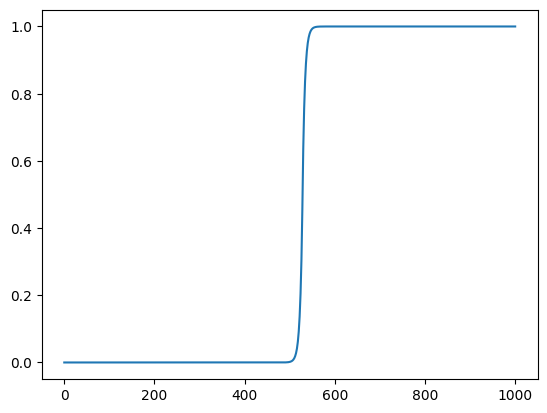

In [12]:
from opendp.extras.numpy.tulap import one_sided_uniformly_most_powerful_tests

ump_tests = one_sided_uniformly_most_powerful_tests(
    theta=theta, epsilon=epsilon, delta=delta, size=1_000, alpha=0.05, tail="left"
)

import matplotlib.pyplot as plt

plt.plot(list(range(0, 1001)), ump_tests);

This visual shows how, when the null hypothesis is that the population rate is no smaller than 0.5, the probability of observing an outcome at least as extreme as theta approaches one.